## IFT 6135-h19 - Assignment 1 - Programming part - Problem 3

### Akila Daniel Jeeson, Myriam Laiymani, Marc-André Piché, Khalil Slimi

## Important notes

- We used for this Kaggle competition, Keras with a TensorFlow backend.
- All our model's best weights saved from training can be downloaded using this link : https://drive.google.com/open?id=1RvCrqWRpWOXbrO6-wh_11QcBmDARXa2P


## Utilities methods

In [1]:
!pip install opencv-python

You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
# Utilities
import numpy as np
import cv2 as cv
import math
import matplotlib.pyplot as plt
import csv

import os
import re

# To reproduce results
seed = 2019


def visualize_training_history(history):
    # Training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


def visualize_cross_validation_history(history_cv):
  
  figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(12, 12))
  
  for i, history in enumerate(history_cv):
    
    # Training & validation accuracy values
    axes[0][0].plot(history.history['acc'],label='Train on fold '+str(i+1))
    axes[0][0].set_title('Model accuracy on training')
    axes[0][0].set_ylabel('Accuracy')
    axes[0][0].set_xlabel('Epoch')
    axes[0][0].legend()

    axes[1][0].plot(history.history['val_acc'],label='Validation on fold '+str(i+1))
    axes[1][0].set_title('Model accuracy on validation')
    axes[1][0].set_ylabel('Accuracy')
    axes[1][0].set_xlabel('Epoch')
    axes[1][0].legend()

    # Training & validation loss values
    axes[0][1].plot(history.history['loss'],label='Train on fold '+str(i+1))
    axes[0][1].set_title('Model loss on training')
    axes[0][1].set_ylabel('Loss')
    axes[0][1].set_xlabel('Epoch')
    axes[0][1].legend()

    axes[1][1].plot(history.history['val_loss'],label='Validation on fold '+str(i+1))
    axes[1][1].set_title('Model loss on validation')
    axes[1][1].set_ylabel('Loss')
    axes[1][1].set_xlabel('Epoch')
    axes[1][1].legend()
    
    
def display_image_grid(imagesArray):
  
    size = imagesArray.shape[0]
    n_cols = 10
    n_rows = (size // n_cols) + 1
    figsize=[n_cols*1.97,n_rows*2]

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    for i in range(n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        if (i < size):
            
            if (size < n_cols):
                axes[col].imshow(imagesArray[i])
                axes[col].set_xticklabels([])
                axes[col].set_yticklabels([])
            else:
                axes[row, col].imshow(imagesArray[i])
                axes[row, col].set_xticklabels([])
                axes[row, col].set_yticklabels([])

        else:
            if (size < n_cols):
                fig.delaxes(axes[col])
            else:
                fig.delaxes(axes[row, col])

    plt.subplots_adjust(wspace=0, hspace=0)


# Write the CSV file for Kaggle
def write_submission_csv(predictions, filename):
    rows = [['id','label']]
    for i, prediction in enumerate(predictions):
        label = categories[prediction]
        rows.append([i+1,label])

    with open(filename, 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(rows)
        
    csvFile.close()

## Data manipulation methods

In [0]:
categories = [
    "Cat","Dog"]

TRAIN_DATA_ROOT_FOLDER = './trainset'
TEST_DATA_ROOT_FOLDER = './testset/test'


# Load the images from files on disk and group them by category
def load_train_data():
    
    cat_images = []
    dog_images = []
    
    for root, dirnames, filenames in os.walk(TRAIN_DATA_ROOT_FOLDER):
        filenames.sort()
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                image = plt.imread(filepath).astype(np.uint8)
                if (image.size == 4096):
                    # If image doesn't have 3 channels, skip it (cleaning training dataset)
                    continue
                if 'Cat' in root:
                    cat_images.append(image)
                elif 'Dog' in root:
                    dog_images.append(image)


    cat_images = np.array(cat_images)
    dog_images = np.array(dog_images)
    return cat_images, dog_images
  
# Load the test images from files on disk
def load_test_data():
    
    test_images = []

    for root, dirnames, filenames in os.walk(TEST_DATA_ROOT_FOLDER):
        filenames.sort(key= lambda x: float(x.strip('.jpg')))
        #print(filenames[-10])
        for filename in filenames:
            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                image = plt.imread(filepath).astype(np.uint8)
                if (image.size == 4096):
                    # If image doesn't have 3 channels, add them
                    image = np.stack((image,) * 3,-1)
                test_images.append(image)
                  
    return np.array(test_images)

  

def train_data_with_labels():
    
    np.random.seed(seed)
    
    dataset_cat, dataset_dog = load_train_data()
    X = np.concatenate((dataset_cat, dataset_dog), axis=0)
    Y = np.array([categories.index('Cat')] * len(dataset_cat) + [categories.index('Dog')] * len(dataset_dog))
    
    # Shuffling
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    X = X[indices]
    Y = Y[indices]
    
    return X, Y

# Prepare the data by formattig it correctly and replacing the categories by ids
def train_valid_split(dataset_cat, dataset_dog, train_size=0.5):
    
    np.random.seed(seed)
    
    train_data_size = int(min(len(dataset_cat), len(dataset_dog))*train_size)
    train_data_cat = dataset_cat[:train_data_size]
    valid_data_cat = dataset_cat[train_data_size:]
    train_data_dog = dataset_dog[:train_data_size]
    valid_data_dog = dataset_dog[train_data_size:]    
    X_train = np.concatenate((train_data_cat, train_data_dog), axis=0)
    X_valid = np.concatenate((valid_data_cat, valid_data_dog), axis=0)
    
    y_train = np.array([categories.index('Cat')] * len(train_data_cat) + [categories.index('Dog')] * len(train_data_dog))
    y_valid = np.array([categories.index('Cat')] * len(valid_data_cat) + [categories.index('Dog')] * len(valid_data_dog))
     
    # Shuffling
    indices = np.arange(X_train.shape[0])
    np.random.shuffle(indices)

    X_train = X_train[indices]
    y_train = y_train[indices]
    
    
    indices = np.arange(X_valid.shape[0])
    np.random.shuffle(indices)

    X_valid = X_valid[indices]
    y_valid = y_valid[indices]
    
    return X_train, X_valid, y_train, y_valid

## Our best performing CNN model - customized VGG-16

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Lambda
from keras import backend as K # We expect TenserFlow as the backend for Keras

def instanciate_model(input_shape=(64,64,3), output_dim=1):

    # We will use the VGG 16 architecture without the fully connected layers
    
    # we initialize the model
    model = Sequential()
 
    # Conv Block 1
    model.add(Conv2D(64, (3, 3), input_shape=input_shape, activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # Conv Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Conv Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    
    # We add our custom layer that averages values of each feature map matrix as a way of flattening the 
    # output to avoid using fully connected layers which increase greatly the number of parameters.
    
    if K.image_data_format() == 'channels_first':
        model.add(Lambda(lambda x: K.mean(x, axis=[2, 3])))
    else:
        model.add(Lambda(lambda x: K.mean(x, axis=[1, 2])))

    model.add(Dense(output_dim, activation='sigmoid'))
    
    return model


Using TensorFlow backend.


## Architecture of the customized VGG-16 model

In [6]:
model = instanciate_model(input_shape=(64,64,3))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 256)       295168    
__________

## Preparation of the data for training (90/10 data split)

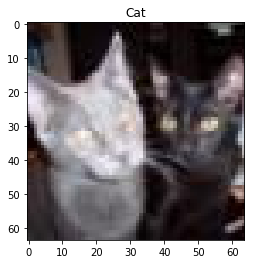

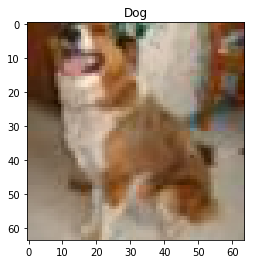

In [0]:
np.random.seed(seed)

from tensorflow import set_random_seed

set_random_seed(seed)

from keras import backend as K

# Loading data
dataset_cat, dataset_dog = load_train_data()

# Splitting data
x_train, x_valid, y_train, y_valid = train_valid_split(dataset_cat, dataset_dog, train_size=0.9)

# Showing some example
plt.figure()
plt.title(categories[y_train[0]])
plt.imshow(x_train[0], cmap='gray')

plt.figure()
plt.title(categories[y_train[1]])
plt.imshow(x_train[1], cmap='gray')


# Reshaping the data format for the CNN input
image_dim = 64
num_channels = 3

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], num_channels, image_dim, image_dim)
    x_valid = x_valid.reshape(x_valid.shape[0], num_channels, image_dim, image_dim)
    input_shape = (num_channels, image_dim, image_dim)
else:
    x_train = x_train.reshape(x_train.shape[0], image_dim, image_dim, num_channels)
    x_valid = x_valid.reshape(x_valid.shape[0], image_dim, image_dim, num_channels)
    input_shape = (image_dim, image_dim, num_channels)
    
    
# Data normalization
x_train_norm = x_train / 255.0
x_valid_norm = x_valid / 255.0


## Hyper-parameters grid search

In [0]:
np.random.seed(seed)
set_random_seed(seed)

from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from sklearn.model_selection import ParameterGrid

# Model params
batch_size_range = [20, 40, 60]
epochs = 20
learning_rate_range = [0.001, 0.01, 0.1]

param_grid = {'batch_size': batch_size_range, 'lr': learning_rate_range}

for params in list(ParameterGrid(param_grid)):

    model = instanciate_model(input_shape=input_shape)

    model.compile(loss=binary_crossentropy,
                  optimizer=SGD(lr=params['lr'], momentum=0.0, decay=0.0, nesterov=False),
                  metrics=['accuracy'])

    model.fit(x_train_norm, y_train,
              batch_size=params['batch_size'],
              epochs=epochs,
              verbose=0,
              validation_data=(x_valid_norm, y_valid))

    score = model.evaluate(x_valid_norm, y_valid, verbose=0)
  
    print('Test loss {} and accuracy {}, for batch size {} and learning rate {}'.format(score[0], score[1], params['batch_size'], params['lr']))


Test loss 0.6928327579548333 and accuracy 0.5777111445469358, for batch size 20 and learning rate 0.001
Test loss 0.46121500853238734 and accuracy 0.7831084458664738, for batch size 20 and learning rate 0.01
Test loss 0.5027329996712264 and accuracy 0.862568715642179, for batch size 20 and learning rate 0.1
Test loss 0.6930151008058345 and accuracy 0.5642178911736225, for batch size 40 and learning rate 0.001
Test loss 0.6411946553816978 and accuracy 0.6286856573799263, for batch size 40 and learning rate 0.01
Test loss 0.48132039802423543 and accuracy 0.7996002000191997, for batch size 40 and learning rate 0.1
Test loss 0.6930557523948558 and accuracy 0.5672163919530351, for batch size 60 and learning rate 0.001
Test loss 0.6916012894148114 and accuracy 0.5502248876753716, for batch size 60 and learning rate 0.01
Test loss 0.4193362710119664 and accuracy 0.7966016992099997, for batch size 60 and learning rate 0.1


## Initial model training

In [0]:
np.random.seed(seed)
set_random_seed(seed)

from keras.losses import binary_crossentropy
from keras.optimizers import SGD

# Model params
batch_size = 20
epochs = 50
learning_rate = 0.1

model = instanciate_model(input_shape=input_shape)

model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

history_overfitting = model.fit(x_train_norm, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_valid_norm, y_valid))


score = model.evaluate(x_valid_norm, y_valid, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 17974 samples, validate on 2001 samples
Epoch 1/50
17974/17974 [==============================] - 58s 3ms/step - loss: 0.6934 - acc: 0.5052 - val_loss: 0.6943 - val_acc: 0.4993
Epoch 2/50
17974/17974 [==============================] - 15s 858us/step - loss: 0.6924 - acc: 0.5172 - val_loss: 0.6986 - val_acc: 0.5007
Epoch 3/50
17974/17974 [==============================] - 15s 859us/step - loss: 0.6866 - acc: 0.5542 - val_loss: 0.6849 - val_acc: 0.5427
Epoch 4/50
17974/17974 [==============================] - 15s 857us/step - loss: 0.6736 - acc: 0.5829 - val_loss: 0.6536 - val_acc: 0.6287
Epoch 5/50
17974/17974 [==============================] - 15s 857us/step - loss: 0.6451 - acc: 0.6307 - val_loss: 0.6198 - val_acc: 0.6702
Epoch 6/50
17974/17974 [==============================] - 15s 856us/step - loss: 0.5923 - acc: 0.6832 - val_loss: 0.5265 - val_acc: 0.7376
Epoch 7/50
17974/17974 [==============================] - 15s 856us/step - loss: 0.5234 - acc: 0.7445 - val_loss: 0.527

## Visualization of the CNN Training (overfitting)

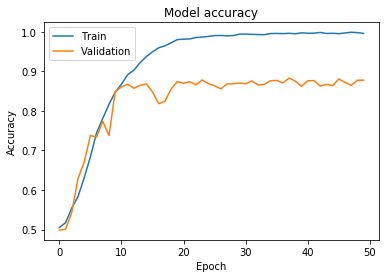

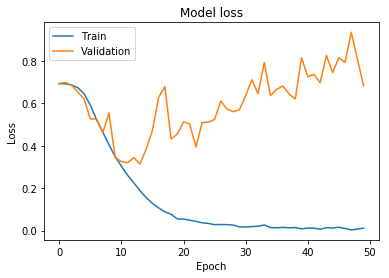

In [0]:
visualize_training_history(history_overfitting)


## Model Training with data augmentation

In [0]:
np.random.seed(seed)
set_random_seed(seed)

from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint

# Model params
batch_size = 20
epochs = 100
learning_rate = 0.1

# Applying different kinds of image transformations to the training data to reduce overfitting without external data

image_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=[0.9, 1.2],
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.5, 1.5])

# Just normalizing the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

model = instanciate_model(input_shape=input_shape)

model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

checkpoint_loss = ModelCheckpoint('weights/model_best_loss_100_epochs.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')

history_data_augmentation = model.fit_generator(image_gen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch= x_train.shape[0]// batch_size,
                    epochs=epochs,
                    verbose=1, 
                    validation_data=val_datagen.flow(x_valid, y_valid, batch_size=batch_size),
                    validation_steps=x_valid.shape[0] // batch_size,
                    callbacks=[checkpoint_loss]
                   )

score = model.evaluate(x_valid_norm, y_valid, verbose=0)
  
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/100
898/898 [==============================] - 30s 33ms/step - loss: 0.6936 - acc: 0.4976 - val_loss: 0.6931 - val_acc: 0.5327
Epoch 2/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6934 - acc: 0.5018 - val_loss: 0.6932 - val_acc: 0.5007
Epoch 3/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6930 - acc: 0.5110 - val_loss: 0.6915 - val_acc: 0.5007
Epoch 4/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6932 - acc: 0.5108 - val_loss: 0.6875 - val_acc: 0.6012
Epoch 5/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6912 - acc: 0.5271 - val_loss: 0.6931 - val_acc: 0.4993
Epoch 6/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6924 - acc: 0.5175 - val_loss: 0.6872 - val_acc: 0.5237
Epoch 7/100
898/898 [==============================] - 29s 32ms/step - loss: 0.6916 - acc: 0.5255 - val_loss: 0.6794 - val_acc: 0.6127
Epoch 8/100
898/898 [==============================] - 

## Visualization of the CNN Training with data augmentation 

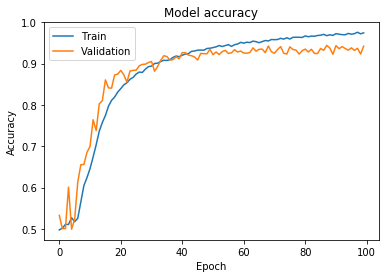

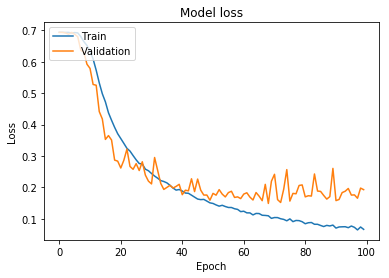

In [0]:
visualize_training_history(history_data_augmentation)

## Quantitative analysis of the results

### Best model's prediction on validation dataset

In [0]:
from keras.optimizers import SGD
from keras.losses import binary_crossentropy

# Loading the best weights for the model and compiling it

model = instanciate_model(input_shape=(64,64,3))
model.load_weights("weights/model_best_loss_100_epochs.h5")
model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

score = model.evaluate(x_valid / 255.0, y_valid, verbose=0)
  
print('Test loss:', score[0])

print('Test accuracy:', score[1])

Test loss: 0.14928041313631066
Test accuracy: 0.9425287356619714


### Confusion matrix on validation dataset

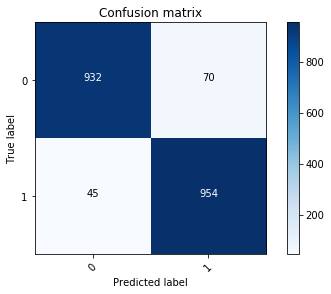

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.optimizers import SGD
from keras.losses import binary_crossentropy


# Code is taken from the Scikit-Learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Loading the best weights for the model and compiling it
model = instanciate_model(input_shape=(64,64,3))
model.load_weights("weights/model_best_loss_100_epochs.h5")
model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])


# Predict the values from the validation dataset
y_pred = model.predict(x_valid / 255.0)
# Convert probabilities to binary predictions (0/1) 
y_pred = np.round(y_pred).astype(int)

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_valid, y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### Best model's prediction on the test dataset (Kaggle)

In [0]:
from keras.optimizers import SGD
from keras.losses import binary_crossentropy

# Loading the best weights for the model and compiling it

model = instanciate_model(input_shape=(64,64,3))
model.load_weights("weights/model_best_loss_100_epochs.h5")
model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

# Loading test data
X_test = load_test_data()

# Reshaping the data format for the CNN input
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])


# Calculate the predictions for the test data amd writing the Kaggle submission file
predictions = model.predict(X_test / 255.0)
predictions = np.round(predictions).flatten()

write_submission_csv(predictions.astype(int), 'Cats_Dogs_64_VGG_AVG_DATA_AUG_LOSS_TUNED.csv') #0.94597

## Qualitative analysis of the results

### Examples of clear misclassification and uncertain prediction

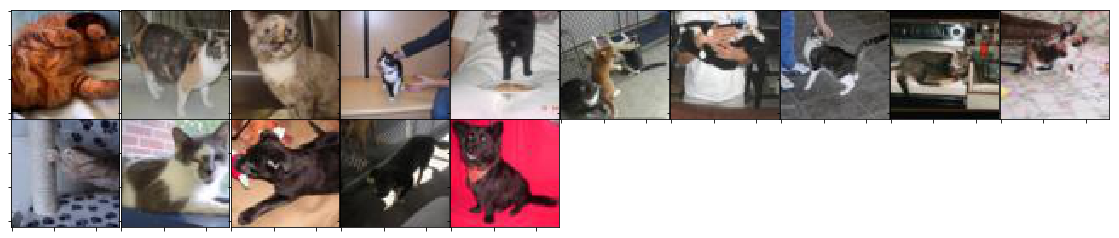

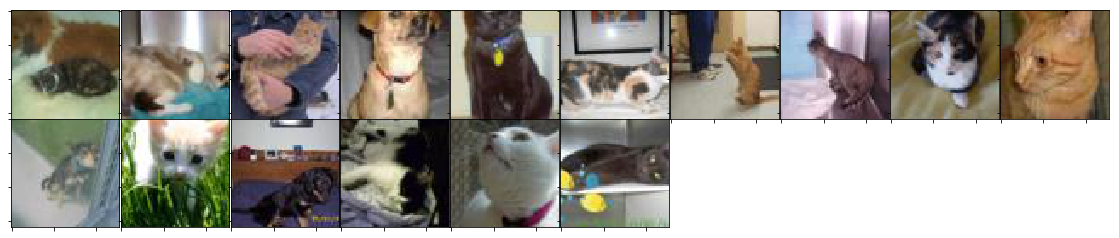

In [0]:
from keras.optimizers import SGD
from keras.losses import binary_crossentropy


# Loading the best weights for the model and compiling it
model = instanciate_model(input_shape=(64,64,3))
model.load_weights("weights/model_best_loss_100_epochs.h5")
model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])


# Predict the values from the validation dataset
y_pred = model.predict(x_valid / 255.0)

clear_misclassifications = []
uncertain_predictions = []

for i in range(len(x_valid)):
    if abs(y_pred[i] - 0.5) <= 0.05:
        uncertain_predictions.append(i)
    if (y_pred[i] >= 0.95 and y_valid[i] == 0) or (y_pred[i] <= 0.05 and y_valid[i] == 1):
        clear_misclassifications.append(i)
        

display_image_grid(x_valid[clear_misclassifications])

display_image_grid(x_valid[uncertain_predictions])


## Model training with 10-fold cross-validation and data augmentation

In [0]:
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint



# Params
batch_size = 20
epochs = 100
seed = 2019
n_folds = 10
learning_rate = 0.1

iteration = 0

np.random.seed(seed)
set_random_seed(seed)

# Load the whole data examples
X, Y = train_data_with_labels()

# Applying different kinds of image transformations to the training data to reduce overfitting without external data
image_gen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.1,
        zoom_range=[0.9, 1.2],
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[0.5, 1.5])

# Just normalizing the validation data
val_datagen = ImageDataGenerator(rescale=1./255)

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
overall_scores = []
hist = []
for train, valid in kfold.split(X, Y):
    x_train_cv = X[train].reshape(X[train].shape[0], input_shape[0], input_shape[1], input_shape[2]) 
    x_valid_cv = X[valid].reshape(X[valid].shape[0], input_shape[0], input_shape[1], input_shape[2])
    y_train_cv = Y[train]
    y_valid_cv = Y[valid]
  
    model = instanciate_model(input_shape=input_shape)
    model.compile(loss=binary_crossentropy,optimizer=SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False),metrics=['accuracy'])
  
    # Save the best results from each fold
    checkpoint_loss = ModelCheckpoint('weights/model_best_loss_fold_'+str(iteration)+'.h5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')
    
    # Saving training history
    hist.append(model.fit_generator(image_gen.flow(x_train_cv, y_train_cv, batch_size=batch_size),
                    steps_per_epoch= x_train_cv.shape[0]// batch_size,
                    epochs=epochs,
                    verbose=0, 
                    validation_data=val_datagen.flow(x_valid_cv, y_valid_cv, batch_size=batch_size),
                    validation_steps=x_valid_cv.shape[0] // batch_size,
                    callbacks=[checkpoint_loss]
                   )
             )

    fold_scores = model.evaluate(x_valid_cv / 255.0, y_valid_cv, verbose=0)
    overall_scores.append(fold_scores[1] * 100)
    iteration += 1

## 10-fold cross-validation results

In [0]:
for acc in overall_scores:
    print('acc: %.2f%%' % acc)
print("%.2f%% (+/- %.2f%%)" % (np.mean(overall_scores), np.std(overall_scores)))

acc: 94.44%
acc: 93.94%
acc: 94.69%
acc: 94.89%
acc: 94.59%
acc: 94.19%
acc: 94.54%
acc: 94.19%
acc: 95.24%
acc: 94.09%
94.48% (+/- 0.38%)


## Visualization of the model training using cross-validation

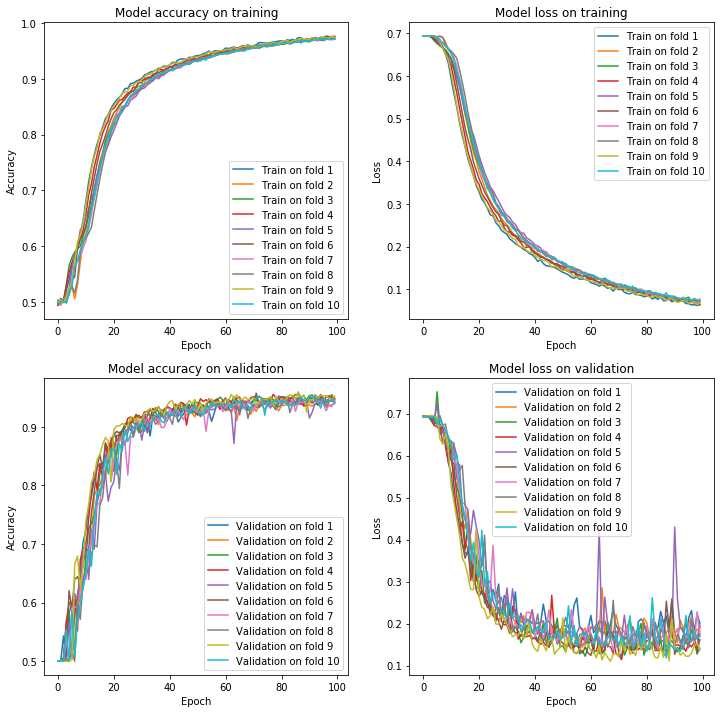

In [0]:
visualize_cross_validation_history(hist)

## Using ensemble vote to improve the classification

In [0]:
def ensemble_predict(best_weights, data):
    '''
    We use this method to use the 10 best models from 10-fold CV
    to do a ensemble prediction of the images in data.
    '''
    ensemble_predictions = np.zeros((data.shape[0],))
    
    for weight in best_weights:
        model = instanciate_model(input_shape=(64,64,3))
        model.load_weights(weight)
        model.compile(loss=binary_crossentropy,
              optimizer=SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])
        
        prediction = model.predict(data / 255.0)
        prediction = np.array(prediction).flatten()
        ensemble_predictions += prediction

    return ensemble_predictions/len(best_weights)

weights_cv = []

# Best weights for each fold
for i in range(10):
    weights_cv.append('weights/model_best_loss_fold_'+str(i)+'.h5')

## Ensemble prediction on test data

In [0]:
# Loading test data
X_test = load_test_data()

# Reshaping the data format for the CNN input
X_test = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[1], input_shape[2])

# Convert probabilities to binary predictions (0/1) 
y_pred = np.round(ensemble_predict(weights_cv, x_valid)).astype(int)
        
write_submission_csv(predictions, 'Cats_Dogs_64_VGG_AVG_CV_10_ENS_CLEAN_LOSS_TUNED.csv')